In [78]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

In [47]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [62]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [3]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [4]:
def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

In [30]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [31]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

In [32]:
context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

In [8]:
num_particles  = 100
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [33]:
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=3.5e-6, nemitt_y=3.5e-6)

In [10]:
#Particles
x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))
y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))

X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
x_norm = X.ravel()
y_norm = Y.ravel()

px_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
delta = np.ones_like(x_norm)*tw.particle_on_co.delta

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, zeta=zeta, delta=delta)

In [11]:
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# Track during RF sweep:
line.scattering.enable()
line.track(particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 95.3s.


- positive and negative sweep
- getting apertures out
- so I need part.at_element, part.at_turn

In [13]:
np.unique(part.at_element, return_counts=True)

(array([25137]), array([100]))

In [15]:
line.element_names[25137], line[25137]

('vcak.52501.a_aper', View of LimitEllipse(a=0.0415, b=0.0415))

# Class

In [189]:
class SweepLosses:
    def __init__(self, line, sweep, plane, num_turns, num_particles=100, nemitt_x=3.5e-6, nemitt_y=3.5e-6, result_name=None, dir=None, gaussian=False):
        self.line = line
        self.sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
        self.num_turns = num_turns
        self.sweep_per_turn = self.sweep/self.num_turns

        self.num_particles = num_particles
        self.gaussian = gaussian

        self.nemitt_x = nemitt_x
        self.nemitt_y = nemitt_y
        if dir is None:
            self.dir = Path.cwd
        else:
            self.dir = dir

        if result_name is None:
            print("WARNING: No result_name provided, using default 'sweep_losses'")
            self.result_name = 'sweep_losses'
        else:
            self.result_name = result_name
        
        self.savedir = Path(self.dir/self.result_name)
        Path(self.savedir).mkdir(parents=True, exist_ok=True)
        
        self.track()

    def make_particles(self):
        if not self.gaussian:
            x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))
            y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))

            X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
            x_norm = X.ravel()
            y_norm = Y.ravel()

            px_norm = np.zeros_like(x_norm)
            py_norm = np.zeros_like(x_norm)
            zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
            delta = np.ones_like(x_norm)*tw.particle_on_co.delta

            return self.line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y, zeta=zeta, delta=delta)
        else:
            return xp.generate_matched_gaussian_bunch(nemitt_x=self.nemitt_x,
                                          nemitt_y=self.nemitt_y,
                                          sigma_z=0.224, num_particles=self.num_particles, line=self.line)

    def track(self):
        tw = self.line.twiss()
        tt = self.line.get_table()
        self.line.collimators.assign_optics(nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y)
        self.part = self.make_particles()

        self.line.discard_tracker()
        self.line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
        rf_sweep = xc.RFSweep(self.line)
        rf_sweep.prepare(sweep_per_turn=self.sweep/self.num_turns)
        rf_sweep.info()
        self.line.scattering.enable()
        self.line.track(particles=self.part, num_turns=self.num_turns, time=True, with_progress=5)
        self.line.scattering.disable()
        print(f"Done sweeping RF in {self.line.time_last_track:.1f}s.")

        self.line.discard_tracker()
        self.line.build_tracker()


    @property
    def aperture_losses(self):
        loss_idxs, loss_counts = np.unique(self.part.at_element, return_counts=True)

        aper_losses = {}
        for idx, count in zip(loss_idxs, loss_counts):
            aper_losses[self.line.element_names[idx]] = int(count)

        json.dump(aper_losses, open(Path(self.savedir)/f'{self.result_name}_aper_losses.json', 'w'), indent=4)
        return aper_losses
    
    @property
    def plot_lossmap(self):
        self.ThisLM = xc.LossMap(self.line, line_is_reversed=False, part=self.part, interpolation=False)
        self.ThisLM.to_json(Path(self.dir)/f'LM_{self.result_name}.json')
        self.ThisLM.plot(savefig=Path(self.savedir)/f'LM_{self.result_name}.pdf')
    
    @property
    def intensity_loss(self):
        fig, ax = plt.subplots(figsize=(12,6))
        turns, counts = np.unique(self.part.at_turn, return_counts=True)
        ax.plot(df_to_delta(self.sweep_per_turn*turns)*1e3, 1-np.cumsum(counts)/self.num_particles, marker='o', color='royalblue')
        ax.grid()
        ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
        ax.set_ylabel('Normalised lost intensity', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        fig.tight_layout()
        fig.savefig(Path(self.savedir)/f'IntensityLoss_{self.result_name}.pdf', dpi=300)
        plt.show()
        return turns, counts
    

    def plot_loss_histogram(self, title="Losses per Element", top_n=None):
        # Optionally limit to top N elements by count
        aper_losses = self.aperture_losses
        items = sorted(aper_losses.items(), key=lambda x: x[1], reverse=True)
        if top_n is not None:
            items = items[:top_n]

        elements, counts = zip(*items)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(range(len(elements)), counts, color="steelblue")
        ax.set_xticks(range(len(elements)))
        ax.set_xticklabels(elements, rotation=90)
        ax.set_xlabel("Element name")
        ax.set_ylabel("Number of losses")
        ax.set_title(title)
        fig.tight_layout()

        return fig, ax

In [95]:
dir = Path('/Users/lisepauwels/sps_simulations/Prototyping/20251008/results/')

In [181]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [182]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

In [183]:
context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

In [184]:
num_particles  = 100
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [ ]:
line['vcak.52501.a_aper'].shift_x -= 1e-3
line['vcak.22501.a_aper'].shift_x -= 1e-3
sim_name = 'case3'
line['vcak.52501.b_aper'].shift_x -= 1e-3
line['vcak.12501.a_aper'].shift_x -= 1e-3

sim_name = 'case4'
line['vtto.52505.a_aper'].shift_x -= 1e-3

sim_name = 'case5'
line['lsd.52505.a_aper'].shift_x -= 1e-3

In [186]:
SL = SweepLosses(line, sweep=sweep, plane=plane, num_turns=num_turns, num_particles=num_particles, nemitt_x=2e-6, nemitt_y=2e-6, result_name=sim_name, dir=dir, gaussian=True)

*** Maximum RMS bunch length 0.23610110400434298m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.2809114751255591
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 81.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


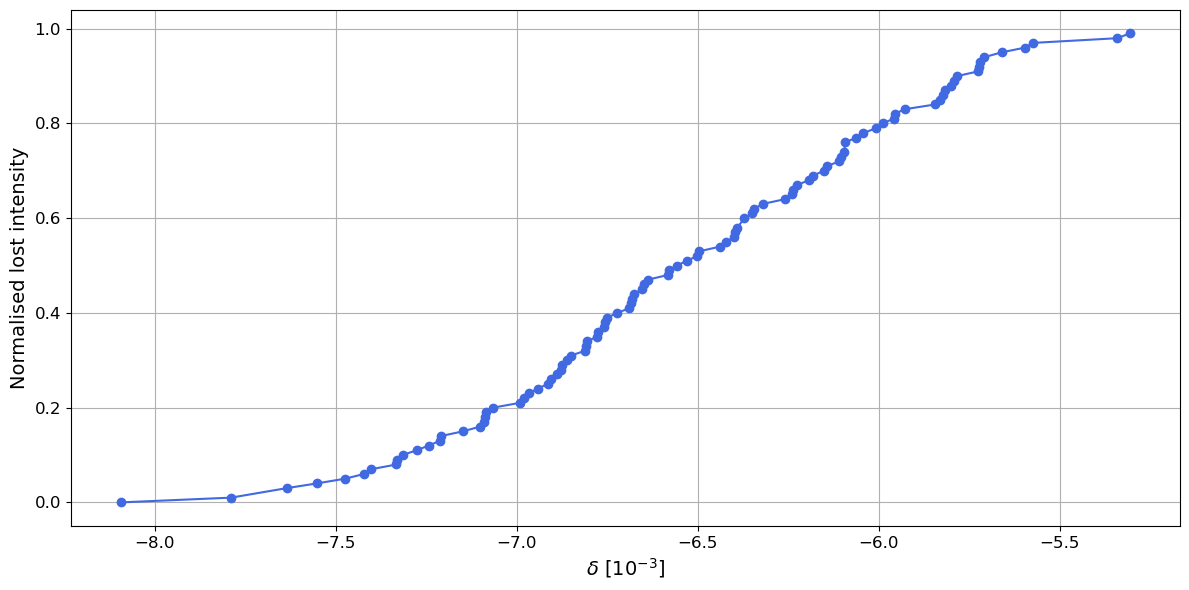

In [187]:
SL.intensity_loss

In [188]:
SL.aperture_losses

{'vcak.22501.b_aper': 21,
 'vcak.32501.a_aper': 19,
 'vcak.42501.a_aper': 9,
 'vcak.52501.a_aper': 4,
 'lsd.52505.a_aper': 42,
 'vcak.62501.a_aper': 5}